# Let's begin with some imports...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
import seaborn as sns

### Load our data

In [2]:
# !wget -O erikas_1min.csv https://raw.githubusercontent.com/erikamoore/fish-sample/master/erika_trial3_out/erika_demo_1min.000_demo_1min.analysis.csv

In [3]:
filename = "erikas_1min.csv"
erika_csv = pd.read_csv(filename)


### Let's take a look at the csv

In [4]:
# erika_csv.info()
erika_csv

,track,frame_idx,instance.score,mouth.x,mouth.y,mouth.score,L_eye.x,L_eye.y,L_eye.score,R_eye.x,R_eye.y,R_eye.score,tail.x,tail.y,tail.score,spine.x,spine.y,spine.score
0,track_0,0,0.972019,596.261047,840.042114,0.934956,620.916626,844.085083,0.948777,616.125183,820.395691,0.877289,704.741333,795.799072,0.710782,668.356567,815.733704,0.950565
1,track_1,0,0.974545,420.429962,899.615723,0.959105,440.819031,908.604370,0.960896,441.098175,888.399353,0.977457,553.003052,899.450134,0.931462,500.563141,899.911865,0.969723
2,track_2,0,1.005324,523.871887,964.498169,0.970140,544.332581,972.058350,0.928870,540.785156,952.224182,0.940794,640.203247,948.660889,0.870511,596.263123,956.080566,0.963090
3,track_3,0,1.024065,349.314941,948.459412,1.011135,364.842743,967.839233,0.986007,372.865112,948.443237,0.973152,460.977173,992.243347,0.870726,412.921112,980.177673,0.962143
4,track_0,1,0.971763,587.767456,841.037659,0.875196,612.336243,847.939331,0.896842,604.681091,824.433044,0.862527,700.540588,796.372375,0.730144,664.036072,816.296265,0.971005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,track_3,1798,0.988827,907.961853,240.078918,0.981445,908.150513,256.708984,1.018302,924.103882,248.655121,0.999357,967.552795,337.069580,0.960892,939.839905,296.779999,0.962862
7153,track_0,1799,0.947037,916.528809,344.508179,0.953227,921.081421,368.882690,0.972961,937.315308,356.524658,0.982653,984.475647,476.745575,0.869862,968.736572,416.430908,0.968650
7154,track_1,1799,0.962379,717.367004,456.214539,0.928877,740.997314,448.224243,1.062302,728.245422,432.307495,1.053027,813.156555,360.240540,0.910354,772.609680,399.784912,1.002383
7155,track_2,1799,0.951281,900.975891,492.720154,0.933361,888.211670,512.396729,0.974422,908.136597,516.853210,0.976720,880.142212,624.477661,0.617232,880.470642,573.203735,0.929498


# Then, do some distance prep...

### Function to calculate distances for a specified pair across all frames directly ✈

In [5]:
def calc_dist_for_pair(df, track1, track2, window_size=50):
    """
    inputs:
      df (DataFrame): df containing tracking data.
      track1 (str): The first track identifier (instance) to filter by.
      track2 (str): The second track identifier (instance) to filter by.

    returns:
      result_df: df containing the frame indices and calculated distance
      (both for a given frame and the rolling average)
    """

    # filter df for desired tracks
    df_track1 = df[df['track'] == track1]
    df_track2 = df[df['track'] == track2]

    # ensure we match frames
    matched_frames = pd.merge(df_track1, df_track2, on='frame_idx', suffixes=('_1', '_2'))

    # extract coordinates
    x1 = matched_frames['spine.x_1'].values
    y1 = matched_frames['spine.y_1'].values
    x2 = matched_frames['spine.x_2'].values
    y2 = matched_frames['spine.y_2'].values

    # calc dist
    # distances = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    distances = np.linalg.norm(np.vstack((x2 - x1, y2 - y1)).T, axis=1) # slightly more efficient but same as line above


    # create result df
    result_df = pd.DataFrame({
        'frame_idx': matched_frames['frame_idx'],
        'track1': track1,
        'track2': track2,
        'distance': distances
    })

    # calc rolling avg of dist
    # 'min_periods=1' to ensure the calculation is done even with fewer items than window size
    result_df['rolling_avg_distance'] = result_df['distance'].rolling(window=window_size, min_periods=1, center=True).mean()


    return result_df


In [6]:
df = erika_csv


### Function to calculate distances for ALL pairs across all frames

In [7]:
track_ids = ['track_0', 'track_1', 'track_2', 'track_3']  # list of track identifiers

In [8]:
def calculate_all_pairs_distances(df, track_ids):
    """calculate distances for ALL pairs across all frames"""
    pairs_distances = []
    for i in range(len(track_ids)):
        for j in range(i + 1, len(track_ids)):
            track1, track2 = track_ids[i], track_ids[j]
            distances = calc_dist_for_pair(df, track1, track2)
            distances['pair'] = f"{track1}-{track2}"
            pairs_distances.append(distances)
    dist_df = pd.concat(pairs_distances)
    pivoted_dist_df = dist_df.pivot(index='frame_idx', columns='pair', values='distance')
    return pivoted_dist_df



In [9]:
all_dists = calculate_all_pairs_distances(df, track_ids)
all_dists

pair,track_0-track_1,track_0-track_2,track_0-track_3,track_1-track_2,track_1-track_3,track_2-track_3
frame_idx,,,,,,
0,187.724790,157.780565,303.791196,110.965803,118.843280,184.918802
1,183.897168,154.002590,298.908174,107.044472,117.100858,182.964005
2,183.646644,152.253065,298.646577,109.263389,117.003259,185.960900
3,183.354375,152.078272,299.685375,109.145834,117.674435,189.135506
4,179.438556,152.002493,300.017697,107.941206,121.982029,189.778874
...,...,...,...,...,...,...
1795,202.300590,175.231301,148.481205,217.937286,183.933073,294.868735
1796,200.899570,176.913058,144.141913,216.110888,186.207898,293.890640
1797,199.405589,179.618050,136.700562,212.861818,186.804640,290.052138


In [10]:
def get_max_distance_coordinates(df, all_dists, track_ids, verbose = False):
    """function to get coordinates of the two fish (such as track_1-track_2) with maximum distance in each frame"""

    # figure out max dist between any two fish for each frame
    max_distances = all_dists.max(axis=1)

    # grab the corresponding pair label (who are the fish for that max dist)
    max_pairs = all_dists.idxmax(axis=1)

    if verbose:
      print(f"max distance between any two fish for the first few frames (across all pairs): {max_distances[0:3]}\n")
      print(f" label of the pair that had the max dist for the first few frames: {max_pairs[0:3]}\n")
      print("for the first few frames, points is:")


    points = []


    for frame_idx in max_pairs.index:
        pair = max_pairs.loc[frame_idx]  # retrieve pair with maximum distance for each frame
        track1, track2 = pair.split('-')  # get the individual track IDs by splitting that label

        # extract the raw coordinates from the original df (SLEAP CSV) for a specific track (fish) at a specific frame
        df_track1 = df[(df['frame_idx'] == frame_idx) & (df['track'] == track1)]
        df_track2 = df[(df['frame_idx'] == frame_idx) & (df['track'] == track2)]

        # make sure we have both fish detected in the frame
        if not df_track1.empty and not df_track2.empty:
            x1, y1 = df_track1[['spine.x', 'spine.y']].values[0]  # we care about the centroids (spine coordinates) for each fish
            x2, y2 = df_track2[['spine.x', 'spine.y']].values[0]
            points.append([(x1, y1), (x2, y2)])
            if verbose and frame_idx in range(0, 3):
                print(f"Frame_idx {frame_idx}, points {points}")
    if verbose:
      print("\n***********************************************************")
      print("resultant array shape: (1800, 2, 2)")
      print("- 1800: Number of frames")
      print("- 2: num of fish pairs (with maximum distance) per frame")
      print("- 2: num of tuples of coordinates (x, y) of the fish in pair for each frame\n")

      print("Now, returning points as an array")
    return np.array(points)

points = get_max_distance_coordinates(df, all_dists, track_ids)
points.shape # array has 1800 frames, each containing 2 pairs of coordinates, and each pair has 2 elements (x, y)

(1800, 2, 2)

In [11]:
# just testing stuff
for pair in points[:3]:
  print(f"pair is \n{pair}")
  print(f"midpoint is {np.mean(pair, axis=0)}\n")

pair is 
[[668.35656738 815.73370361]
 [412.92111206 980.17767334]]
midpoint is [540.63883972 897.95568848]

pair is 
[[664.03607178 816.29626465]
 [411.70718384 976.53430176]]
midpoint is [537.87162781 896.4152832 ]

pair is 
[[660.63830566 816.64038086]
 [407.97528076 975.86090088]]
midpoint is [534.30679321 896.25064087]



## function to convert cartesian to polar coords

In [12]:
# polar coordinates technically make more sense
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta



---


# Now, our attempts to find the center can begin in earnest:


---



# Method 1: The 'midpoint' method

In [13]:
# function to find the center from the midpoints of the maximum distance pairs
def find_center_from_midpoints(points):
    midpoints = []

    for pair in points:
        midpoint = np.mean(pair, axis=0)
        midpoints.append(midpoint)

    midpoints = np.array(midpoints)
    center_x = np.mean(midpoints[:, 0])
    center_y = np.mean(midpoints[:, 1])
    return center_x, center_y



# Calculate the center from the midpoints
center = find_center_from_midpoints(points)
print(f"Estimated center of the tank: {center}")

mid_cx, mid_cy = center[0], center[1]
print(f"\nStoring coordinates for the mid method center in mid_cx = {mid_cx}, mid_cy = {mid_cy}")


polar_coordinates = cartesian_to_polar(center[0], center[1])
print(f"Polar coordinates of the center: (r = {polar_coordinates[0]}, theta = {polar_coordinates[1]})")

Estimated center of the tank: (524.6622194268969, 568.6876277393765)

Storing coordinates for the mid method center in mid_cx = 524.6622194268969, mid_cy = 568.6876277393765
Polar coordinates of the center: (r = 773.7415992679965, theta = 0.8256429554683408)


## a function to check my work

In [14]:
## Check my work

fps = 30  # frames per second (i have verified this number)

# Function to calculate distances to the estimated center
def calculate_distances_to_center(df, estimated_center):
    cx, cy = estimated_center
    df['distance_to_center'] = np.sqrt((df['spine.x'] - cx)**2 + (df['spine.y'] - cy)**2)
    return df

# Function to find the frame with the fish closest to the estimated center
def find_closest_fish_frame(df, estimated_center):
    df = calculate_distances_to_center(df, estimated_center)
    closest_fish = df.loc[df['distance_to_center'].idxmin()]
    return closest_fish

In [15]:
# Get the closest fish frame
closest_fish_frame = find_closest_fish_frame(df, center)
frame_index = closest_fish_frame['frame_idx']
time_in_seconds = frame_index / fps

print(f"Frame with fish closest to estimated center: {frame_index}\n")
print(f"Closest fish details:\n{closest_fish_frame}")
print(f"\nTime in the video: {time_in_seconds:.2f} seconds")

Frame with fish closest to estimated center: 1568

Closest fish details:
track                    track_3
frame_idx                   1568
instance.score          0.969071
mouth.x               593.536011
mouth.y               579.985657
mouth.score             0.930482
L_eye.x               577.159485
L_eye.y               564.293213
L_eye.score             0.973023
R_eye.x                573.07312
R_eye.y               581.178345
R_eye.score             0.967632
tail.x                480.734375
tail.y                556.708984
tail.score              0.877571
spine.x                524.75293
spine.y               564.443726
spine.score              0.95393
distance_to_center      4.244871
Name: 6232, dtype: object

Time in the video: 52.27 seconds


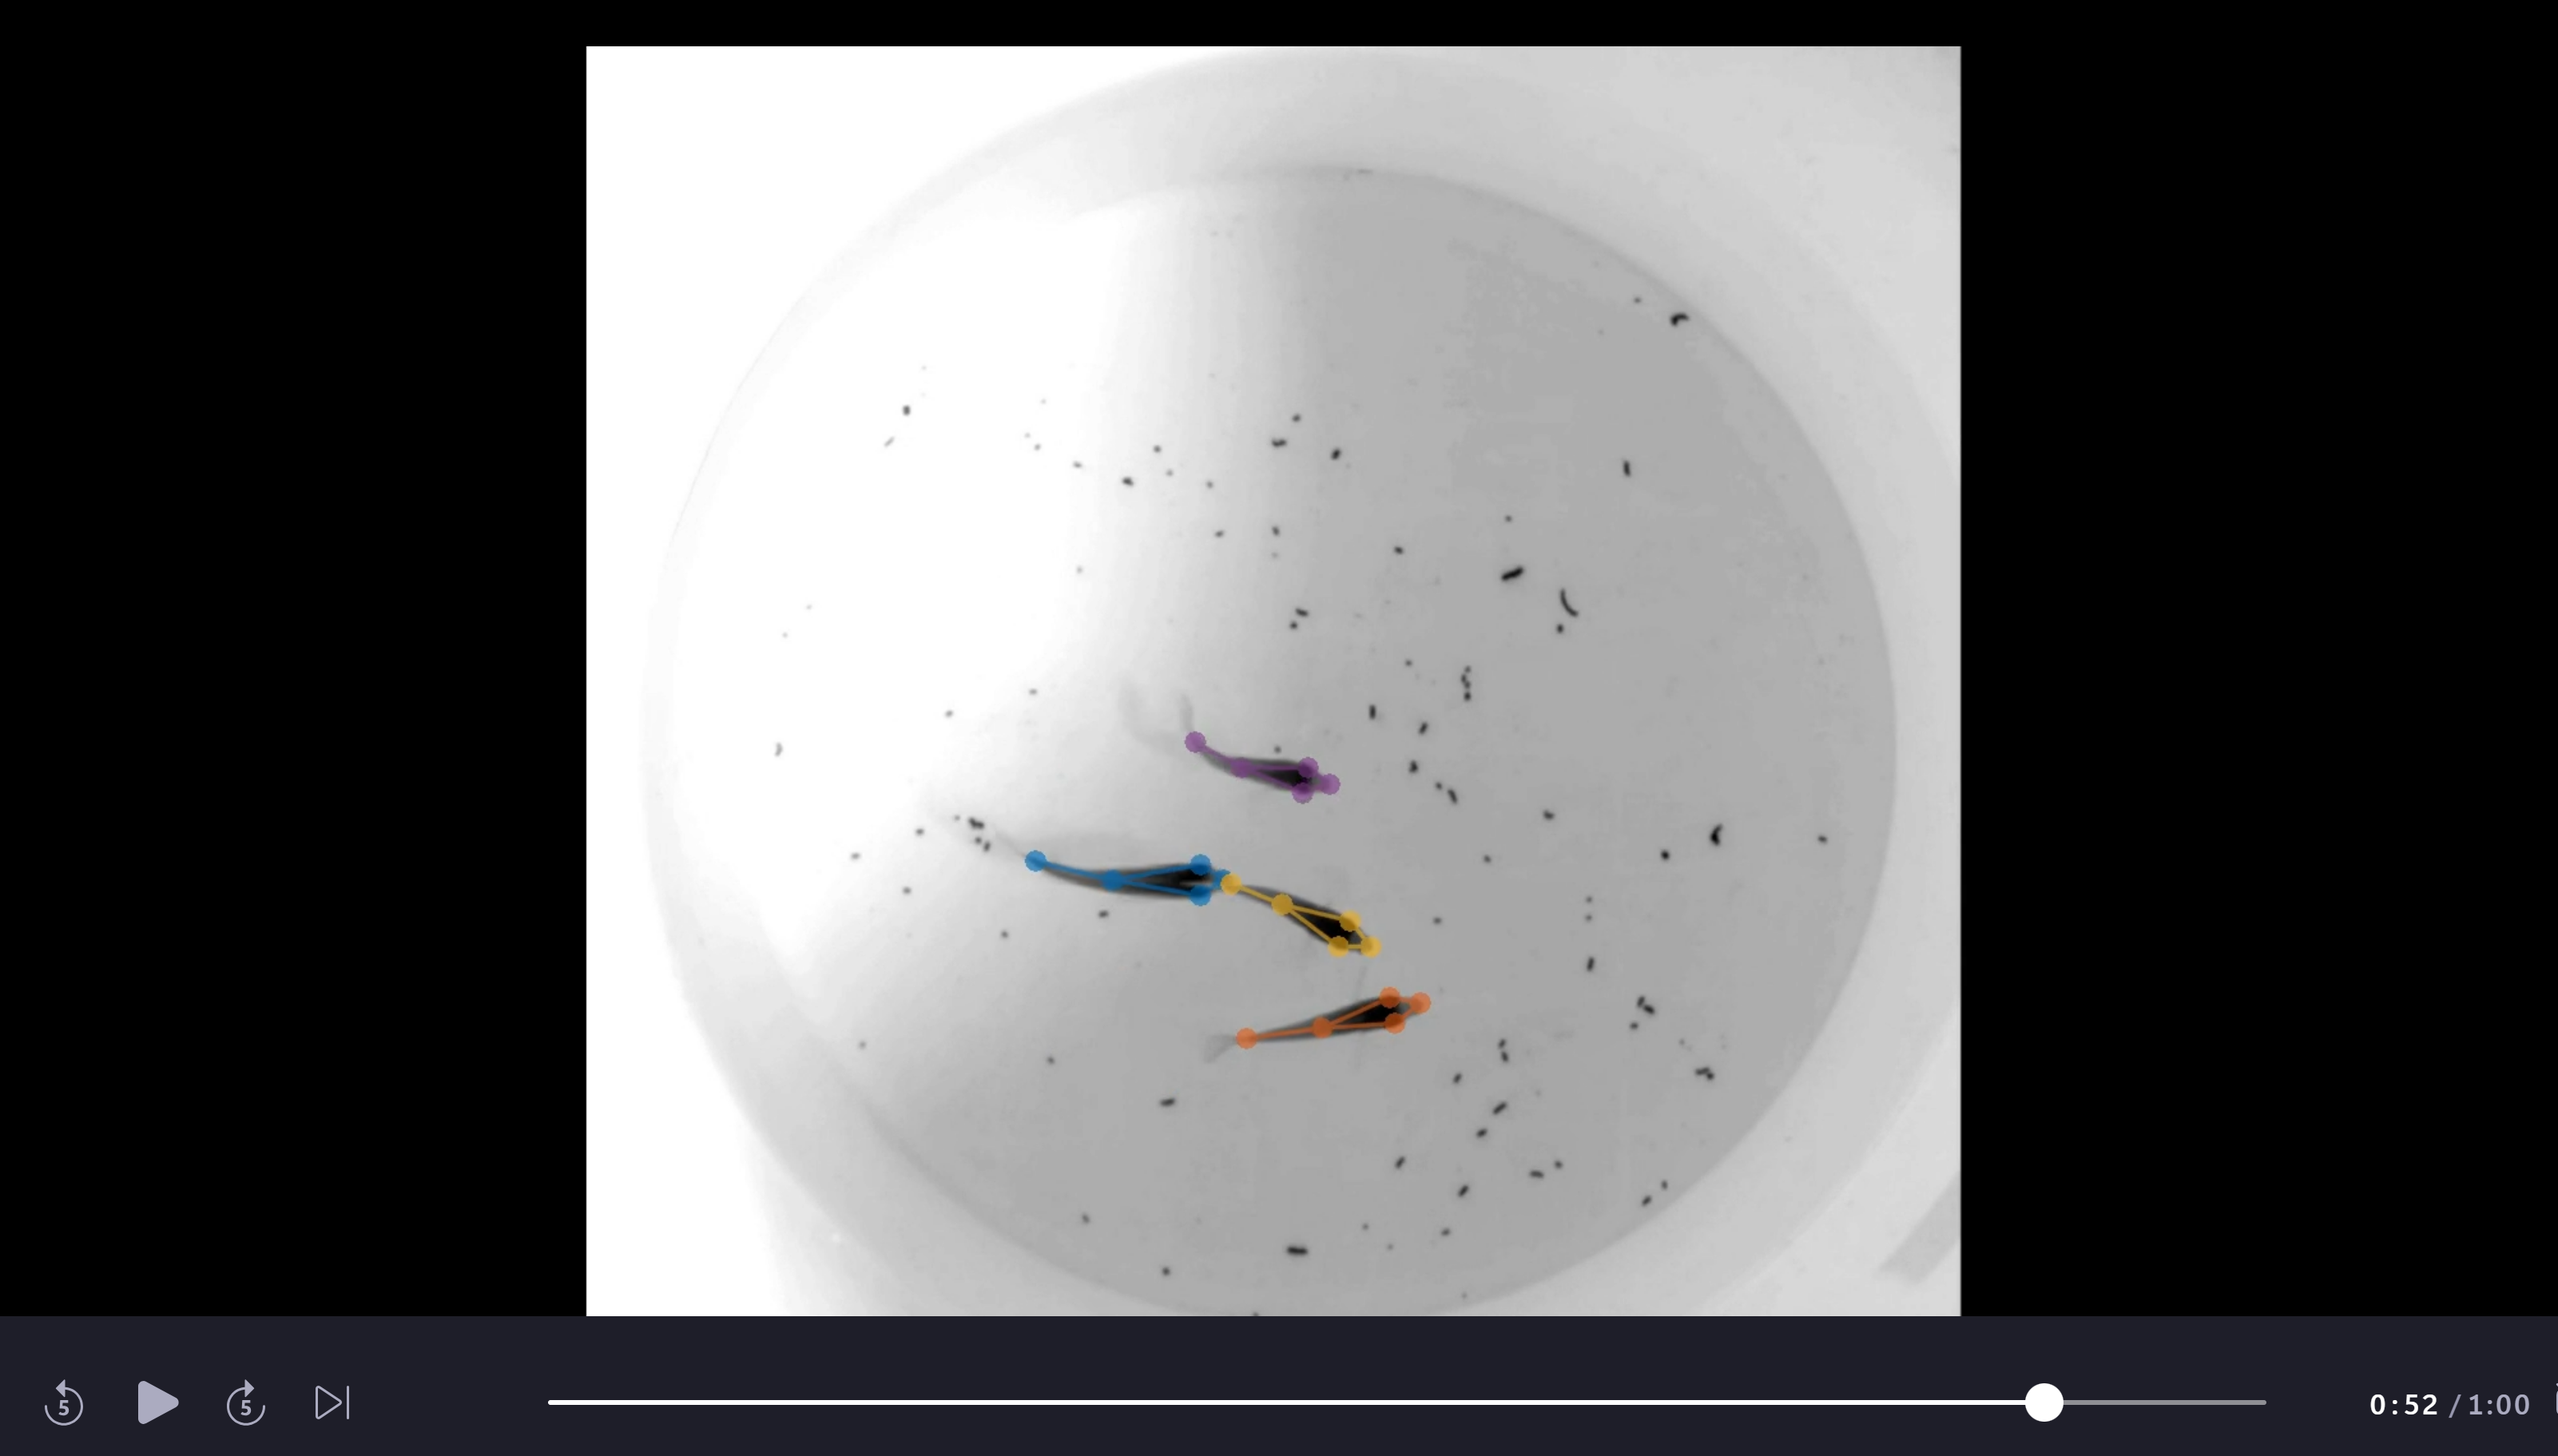

In [16]:
# Calculate distances from the closest fish to other fish in the same frame
track_id_closest_fish = closest_fish_frame['track']
distances_to_other_fish = {}

for pair in all_dists.columns:
    if track_id_closest_fish in pair:
        distances_to_other_fish[pair] = all_dists.loc[frame_index, pair]

print(f"\nDistances from closest fish to other fish in the same frame:")
for pair, distance in distances_to_other_fish.items():
    other_fish = pair.replace(track_id_closest_fish, '').replace('-', '')
    print(f"Distance to {other_fish}: {distance:.2f}")


Distances from closest fish to other fish in the same frame:
Distance to track_0: 136.81
Distance to track_1: 209.82
Distance to track_2: 109.10


# Method 2: The 'least square' method



---


## does least squares fit a circle to estimate the center more precisely? actually, this is a bit hard to say.

In [17]:
from scipy.optimize import least_squares

# maybe we can fit a circle to estimate the center more precisely

def calc_distances_from_center(params, points):
    """function to calculate distances from each coordinate to the estimated center"""
    cx, cy = params     # cx, cy is just some estimated center (cx, cy)

    # basically we get rid of the extra set of brackets showing that groups each set of two fish
    points = points.reshape(-1, 2)  # so first column is all of those x coords and second col is all of those y coords after we reshape

    return np.sqrt((points[:, 0] - cx) ** 2 + (points[:, 1] - cy) ** 2) # dist of all coordinates to estimated center

def circle_fit_error(params, points):
    """error function to be minimized
       we calculate the residuals between the actual distances of points from the estimated center and the mean distance
       since for a perfect circle, all points are equidistant from the center (constant radius), so we aim to make these residuals as close to 0 as possible.
    """
    # on the first iteration the initial_guess gets passed in as the params
    # with each update, the new cx, cy (our 'better' guess for the center) gets passed in as 'params'
    # calc the distance between each coord in points and our new center
    distances = calc_distances_from_center(params, points)
    # print(f"params is {params}")

    # rep the error as the distances of our original points from that center (cx,cy) minus the mean of those distances
    return distances - np.mean(distances)

def fit_circle(points):
    """ function to fit a circle and find the center """
    points = points.reshape(-1, 2)  # Ensure points are reshaped correctly
    initial_guess = np.mean(points, axis=0)  # Start with our center 'guess' as the mean of all the x's and the mean of all the y's

    # least_squares function from scipy.optimize aims to find parameters that minimize sum of squared residuals (errors)
    # It takes 3 arguments:
    # circle_fit_error is the function we want to minimize
    # initial_guess is just a starting point for the algorithm to try to improve upon (center of the circle initial guess)
    # args=(points,) tells least_squares to pass points (our array of fish coordinates) to circle_fit_error
    result = least_squares(circle_fit_error, initial_guess, args=(points,))  # The purpose of least_squares is to reduce the effect of outliers on the soln
    return result.x

# fit the circle to the points
center_circle_fit = fit_circle(points)
print(f"\nAdjusted center of the tank (circle fit): {center_circle_fit}")

ls_cx, ls_cy = center_circle_fit[0], center_circle_fit[1]
print(f"\nStoring coordinates for the least squares circle fit center in ls_cx = {ls_cx}, ls_cy = {ls_cy}")


Adjusted center of the tank (circle fit): [549.74621959 524.28240998]

Storing coordinates for the least squares circle fit center in ls_cx = 549.7462195907023, ls_cy = 524.2824099797863


In [18]:
r, theta = cartesian_to_polar(center_circle_fit[0], center_circle_fit[1])
print(f"Polar coordinates of the center: (r = {r}, theta = {theta})") # notice these are not typical polar coordinates for a center... this prompts us to adjust (see later code)


Polar coordinates of the center: (r = 759.6663421321767, theta = 0.7616939161983415)


## use the function to check my work

In [19]:
# get the closest fish frame
closest_fish_frame = find_closest_fish_frame(df, center_circle_fit)
frame_index = closest_fish_frame['frame_idx']
time_in_seconds = frame_index / fps

print(f"Frame with fish closest to estimated center: {frame_index}\n")
print(f"Closest fish details:\n{closest_fish_frame}")
print(f"\nTime in the video: {time_in_seconds:.2f} seconds")


Frame with fish closest to estimated center: 1084

Closest fish details:
track                    track_2
frame_idx                   1084
instance.score          0.961747
mouth.x               479.933777
mouth.y                564.18811
mouth.score             0.899934
L_eye.x               503.755707
L_eye.y               561.202393
L_eye.score             0.935699
R_eye.x               495.627686
R_eye.y               544.391602
R_eye.score             0.894649
tail.x                592.755737
tail.y                 488.59375
tail.score              0.896212
spine.x               556.120483
spine.y                524.68457
spine.score             0.978991
distance_to_center      6.386938
Name: 4309, dtype: object

Time in the video: 36.13 seconds


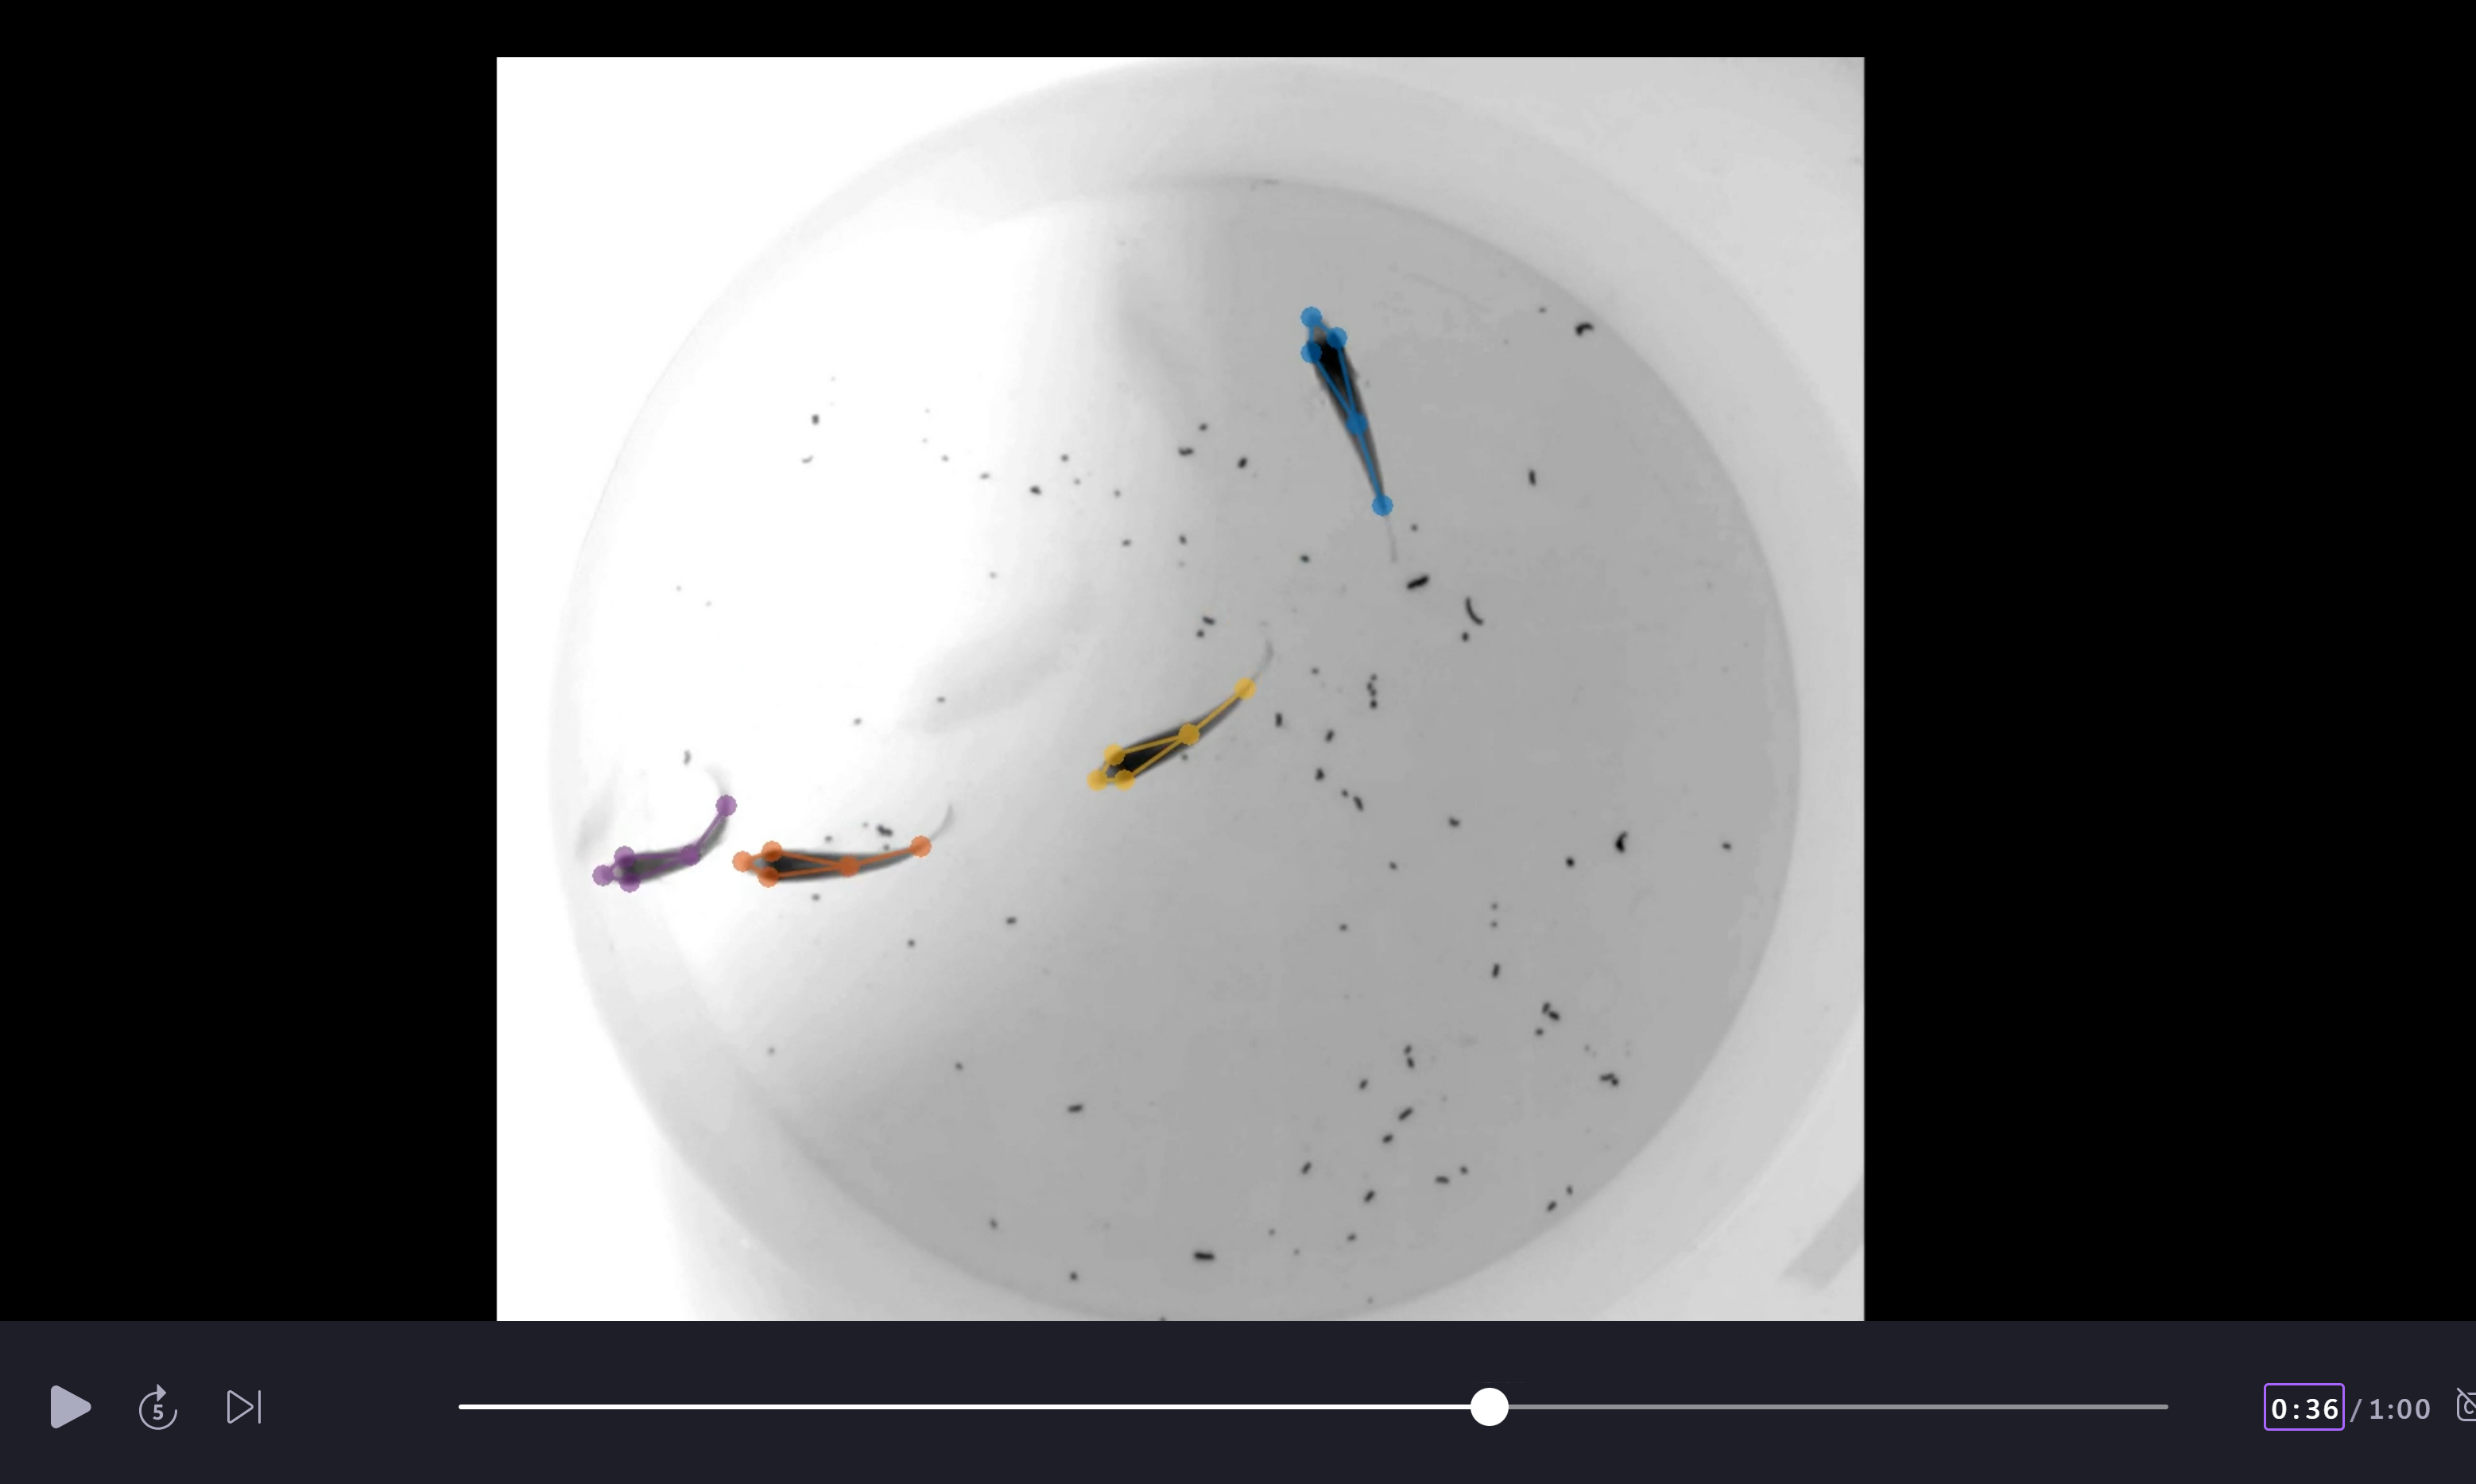

In [20]:
# calculate distances from the closest fish to other fish in the same frame
track_id_closest_fish = closest_fish_frame['track']
distances_to_other_fish = {}

for pair in all_dists.columns:
    if track_id_closest_fish in pair:
        distances_to_other_fish[pair] = all_dists.loc[frame_index, pair]

print(f"\nDistances from closest fish to other fish in the same frame:")
for pair, distance in distances_to_other_fish.items():
    other_fish = pair.replace(track_id_closest_fish, '').replace('-', '')
    print(f"Distance to {other_fish}: {distance:.2f}")


Distances from closest fish to other fish in the same frame:
Distance to track_0: 264.88
Distance to track_1: 291.92
Distance to track_3: 412.11


In [21]:

# standard_colors = [
#     (0/255, 114/255, 189/255),    # Blue -- track 0
#     (217/255, 83/255, 25/255),    # Orange  -- track 1
#     (237/255, 177/255, 32/255),   # Yellow -- track 2
#     (126/255, 47/255, 142/255)    # Purple -- track 3
# ]




---


# hmmm...do you think the 'best' center of the circle was the one most 'mid' or the one 'least square'?